# Diffusion models

Blog posts/reviews:
- [Lilian Weng's blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
- [Yang Song's blog post](https://yang-song.net/blog/2021/score/)
- [Alex Alemi's blog post](https://blog.alexalemi.com/diffusion.html)
- [Understanding Diffusion Models: A Unified Perspective by Calvin Luo](https://arxiv.org/abs/2208.11970)
  
Relevant papers:
- [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)
- [Score-Based Generative Modeling through Stochastic Differential Equations](https://arxiv.org/abs/2011.13456)
- [Maximum Likelihood Training of Score-Based Diffusion Models](https://arxiv.org/abs/2101.09258)


In [1]:
from functools import partial

import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

## The dataset

We'll use two moons to keep things simple.

(-2.0, 2.0)

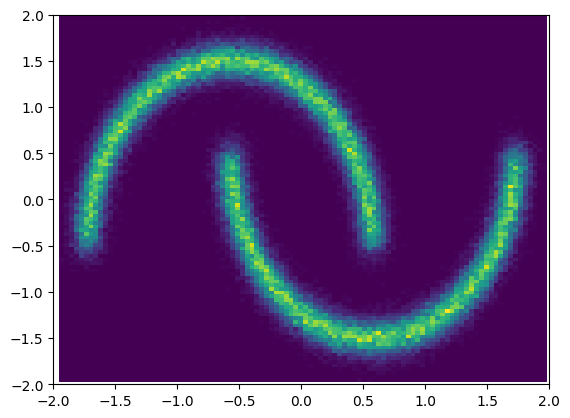

In [2]:
n_samples = 100_000

x, _ = datasets.make_moons(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

## Denoising diffusion

Denoising diffusion can be viewed as a hierarchical VAE, with a few restrictions on the architecture:
1. The dimensionality of the latents at different hierarchical levels and the data are the same (although this can be relaxed for latent diffusion).
2. The encoder is not learned; instead, the encoding processes are Markovian $q(x_t\mid x_{t-1})$ and correspond to a Gaussian distributions with mean corresponding to the output of the previous encoding step, $$q\left({x}_t \mid {x}_{t-1}\right)=\mathcal{N}\left(\sqrt{1 - \beta_t}\, {x}_{t-1},\beta_t \mathbb{I}\right)$$
where $\beta_t$ is a fixed or learnable variance schedule, and we've decided that the variance of the latents is preserved at various hierarchies (timesteps). This is the forward diffusion process.
3. The distribution of latents at the final timestep is a standard Gaussian (similar to a regular VAE).

### The forward process

We have $q\left({x}_t \mid {x}_{t-1}\right)=\mathcal{N}\left(\sqrt{1 - \beta_t}\, {x}_{t-1},\beta_t \mathbb{I}\right)$. During training, it will be useful to have a closed-form expression for $q(x_t\mid x_0)$. See Eqs. (61)-(70) of [2208.11970](https://arxiv.org/abs/2208.11970); with $\alpha_t\equiv 1 - \beta_t$ we have
$$q(x_t\mid x_0) = \mathcal N(\sqrt{(\overline{\alpha}_t)} x_0, \sqrt{(1 - \overline{\alpha}_t)}\mathbb I )$$
with $\overline{\alpha}_t = \prod_{i=1}^t \alpha_i$ which is sometimes called the diffusion kernel.

### Optimizing variational lower bound

As for any VAE and exactly as in the previous notebook, we can optimize a variational lower bound on the log-evidence through the ELBO by enforcing a consistency between forward and reverse diffusion processes at each timestep. This gives
$$\mathrm{ELBO} = L_0 + \sum_{t=2}^T L_t + L_T$$ 
where $L_0 = \log p_\theta(x_0\mid x_1)$ is a reconstruction loss, with data samples $x_0 \mid p(x_0)$. $L_T = -D_\mathrm{KL}\left(q_\phi(x_T|x_0)\,\|\,p(x_T)\right)$ is the prior matching term with $p(x_T) = \mathcal N(0, \mathbb I)$, and
$$L_t = -D_{\mathrm{KL}}\left(q\left({x}_{t - 1} \mid {x}_{t}, {x}_0\right) \|\,p_\theta\left({x}_{t-1} \mid {x}_{t}\right)\right)$$
is the diffusion consistency term which imposes a consistency between the forward and reverse diffusion processes. $q(x_{t-1}\mid x_t)$ has an analytic form, with variance
$$
\sigma_q^2(t)=\frac{\left(1-\alpha_t\right)\left(1-\overline{\alpha}_{t-1}\right)}{1-\overline{\alpha}_t}.
$$
The variances of the forward and reverse processes can be enforced to be the same, so computing the KL-divergence essentially boils down to matching the means. Eventually, the diffusion consistency loss simplifies as
$$
\frac{1}{2 \sigma_q^2(t)} \frac{\overline{\alpha}_{t-1}\beta_t^2}{\left(1-\overline{\alpha}_t\right)^2}\left[\left\|\hat{{x}}_{{\theta}}\left({x}_t, t\right)-{x}_0\right\|^2\right]
$$
and equivalently as
$$
\frac{1}{2 \sigma_q^2(t)} \frac{\beta_t^2}{\left(1-\overline{\alpha}_t\right) \alpha_t}\left[\left\|\hat{{\epsilon}}_{{\theta}}\left({x}_t, t\right) - {\epsilon}_0\right\|^2\right]
$$
which correspond to original-data prediction and noise prediction, respectively.

### Implementation

Let's implement this pretty much exactly as outlined above.

In [3]:
class MLP(nn.Module):
    """ A simple MLP in Flax. This is the noise-prediction or score function.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 2

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [4]:
def beta_t(t, t_min=1e-4, t_max=0.02):
    """ Linear variance schedule
    """
    return t_min + (t_max - t_min) * t

def alpha_t(t, t_min=1e-4, t_max=0.02):
    """ 1 - beta_t
    """
    return 1 - beta_t(t, t_min, t_max)

def alpha_t_bar(t_n, t_N=100, t_min=1e-4, t_max=0.02):
    """ Reparameterized (1 - sigma^2) for q(x_t | x_0)
    """
    alpha_t_ary = jax.vmap(alpha_t, in_axes=(0,None,None))(np.arange(t_N) / t_N, t_min, t_max)
    alpha_t_cumprod = np.cumprod(alpha_t_ary)
    return alpha_t_cumprod[t_n]

def sigma_q2(t_n, t_N=100, t_min=1e-4, t_max=0.02):
    """ Standard deviation of q(x_{t-1} | x_t)
    """
    return (1 - alpha_t(t_n, t_min, t_max)) / (1 - alpha_t_bar(t_n, t_N, t_min, t_max)) * (1 - alpha_t_bar(t_n - 1, t_N, t_min, t_max))
    
def weight(t):
    return 1.


@partial(jax.jit, static_argnums=(3,))
def loss_fn(params, x, t_n, score, key):
    eps = jax.random.normal(key, shape=x.shape)
    alpha_t_bar_ary = jax.vmap(alpha_t_bar, in_axes=(0,None,None,None))(t_n, t_N, 1e-4, 0.02)
    x_t = np.sqrt(alpha_t_bar_ary) * x + np.sqrt(1 - alpha_t_bar_ary) * eps
    eps_pred = score.apply(params, np.concatenate([x_t, t_n / t_N], -1))    
    return weight(t_n / t_N) * np.mean((eps - eps_pred) ** 2)


n_smoke_test = 16

key = jax.random.PRNGKey(0)
t_n = np.arange(n_smoke_test)[:, None]
t_N = n_smoke_test

score = MLP(hidden_dim=128, out_dim=2, n_layers=5)
params = score.init(key, np.concatenate([x[:n_smoke_test], t_n / t_N], axis=1))

loss_fn(params, x[:n_smoke_test], t_n[:n_smoke_test], score, key)

Array(0.8073362, dtype=float32)

We ignore the weighting prefactor in the noise-matching term. Empirically, [2006.11239](https://arxiv.org/abs/2006.11239) found that this leads to better performance compared to using the weighting (which corresponds to maximimizing the ELBO). 

This doesn't seem theoretically grounded; however, in [2303.00848](https://arxiv.org/abs/2303.00848) they interpret this as using a weighted sum (over timesteps or noise levels) of different ELBO objectives, somewhat equivalent to using a per-timestep data augmentation scheme.

### Train

In [5]:
opt = optax.adam(learning_rate=3e-4)
opt_state = opt.init(params)

In [6]:
n_steps = 5_000
n_batch = 128
t_N = 100

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        t_n_batch = jax.random.choice(key, t_N, shape=(x_batch.shape[0], 1))

        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, t_n_batch, score, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:42<00:00, 117.18it/s, val=0.6675024] 


### Sampling

The simple way to sample is through ancestral sampling from 
$$q(x_0\mid x_T) = \prod_{i = 0}^{t-1} q(x_t \mid x_{t + 1})$$
with
$$q(x_{t - 1} \mid x_{t}) = \mathcal N\left(\frac{1}{\sqrt{\alpha_t}}\left({x}_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}} {\epsilon}_\theta\left({x}_t, t\right)\right), \sigma_t \mathbb I\right)
$$
where $x_T \sim \mathcal N(0, \mathbb I)$.

In [7]:
def single_sample_fn(score, params, key, t_N=50, lambda_ddpm=1.):
    """ Ancestral sampling with `t_N` timesteps.
        `lambda_ddpm = 1` corresponds to the DDPM, `lambda_ddpm = 0` corresponds to the DDIM.
    """

    x_t = jax.random.normal(key, (2,))

    for t_i in range(t_N, 0, -1):

        t = (t_i / t_N)

        t = np.atleast_1d(t)
        
        key, _ = jax.random.split(key)
        eps = jax.random.normal(key, shape=x_t.shape) 
        eps_pred = score.apply(params, np.concatenate([x_t, t], axis=-1))

        # Often just sigma_t = beta_t is taken for simplicity
        sigma_t = np.sqrt((1 - alpha_t_bar(t_i - 1, t_N)) / (1 - alpha_t_bar(t_i, t_N)) * beta_t((t)))

        x_t = 1 / (np.sqrt(alpha_t(t))) * (x_t - (1 - alpha_t(t)) / (np.sqrt(1 - alpha_t_bar(t_i, t_N))) * eps_pred) + lambda_ddpm * sigma_t * eps
        
    return x_t


key = jax.random.PRNGKey(42)
single_sample_fn(score, params, key, t_N=50, lambda_ddpm=1.)

Array([-1.3910006,  1.0375434], dtype=float32)

The pre-factor `lambda_ddpm` weighs the amount of "stochasticity" in sampling, with `lambda_ddpm=0` corresponding to a deterministic sampling from the Gaussian latents (DDIM; [2010.02502](https://arxiv.org/abs/2010.02502)) and `lambda_ddpm=1` is the usual DDPM stochastic sampling.

In [8]:
sample_fn = partial(single_sample_fn, score, params, t_N=50)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)


(-2.0, 2.0)

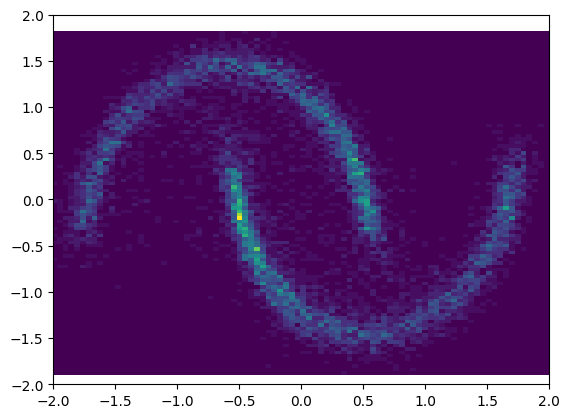

In [9]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

## Stochastic differential equations and diffusion models

The variance-preserving DDPM perturbation kernel above
$$ x_{t} = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon_{t - 1}$$
in the limit of infinite timesteps can be modeled by a variance-preserving SDE:
$$\mathrm dx(t) = -\frac{1}{2}\beta(t)x(t)\mathrm dt + \sqrt{\beta(t)}\mathrm d w(t)$$
for $t\in[0, 1]$. The mean and variance of this VP-SDE are given in terms of the integral of beta (`int_beta` here); see Eq. (29) of [Song et al (2020)](https://arxiv.org/abs/2011.13456) for details. This would be the analogy of $\prod_t \alpha_t$ in DDPM above.

**Noise-corruption and the forward process:** Data $x\in \mathbb R^d$. Represent the stochastic (noise-corruption, forward) process as the solution to an SDE,
$$\mathrm dx = f(x, t)\mathrm dt + g(t)\mathrm dw$$ 
where $f: \mathbb R^d \rightarrow \mathbb R^d$ is the (deterministic) drift coefficient and $g(t): \mathbb R \rightarrow \mathbb R$ is the diffusion coefficient. $w$ is Brownian motion (Weiner process) with $\mathrm dw$ representing infinitesimal white noise.

The solution to this SDE is a continuous collection of random variables $\{x(t)\}_{t\in[0, T]}$. $p_t(x)$ is the marginal distribution of $x(t)$; $x\sim p_0(x)$ is the data distribution, and we take $p_T(x)$ to be close to a prior distribution $\pi(x)$ (typically a standard Gaussian) for some sufficiently large $T$.

The choice of SDE dictates the form of the the noise-corruption process.

The score model $s_\theta$ is trained using the denoising score-matching objective:
$$\mathbb{E}_{t \sim \mathcal U[0, 1]} \mathbb{E}_{x(0) \sim p_0(x)} \mathbb{E}_{x(t)\sim p_t(x(t) \mid x(0)) } \lambda(t)\left\|s_\theta(t, x(t))-\nabla_x \log p(x(t) \mid x(0))\right\|^2$$
where for an affine transition probability we can get this analytically, noting
$$s_\theta(x(t), t) - \nabla_x(t)\log p_t(x(t)\mid x(0)) = s_\theta(x(t), t) + \frac{x(t) - \mu}{\sigma^2} = s_\theta(x(t), t) + \epsilon / \sigma $$
where $\mu$ and $\sigma$ are the mean and standard deviation of the transition probability $p_t(x(t) \mid x(0))$ as noted above, and $\epsilon$ is the added noise.

The score $s_\theta(x_t, t)$ therefore is equivalent to the noise-prediction model $\epsilon_\theta(x_t, t)$, up to the time-dependent variance scaling term. 

In [10]:
def int_beta(t):
    return t

def alpha(t):
    """ Mean of perturbation kernel q(x_t | x_0)
    """
    return np.exp(-0.5 * int_beta(t))

def sigma(t):
    """ Standard deviation of perturbation kernel q(x_t | x_0)
    """
    return np.sqrt(1 - np.exp(-int_beta(t)))

@partial(jax.jit, static_argnums=(3,4,))
def loss_fn(params, x, t, int_beta, score, key):
    eps = jax.random.normal(key, shape=x.shape)
    x_t = alpha(t) * x + sigma(t) * eps
    pred = score.apply(params, np.concatenate([x_t, t], -1))
    return np.mean((pred + eps / sigma(t)) ** 2)

In [11]:
key = jax.random.PRNGKey(0)
t = np.ones((x.shape[0], 1))

score = MLP(hidden_dim=128, out_dim=2, n_layers=5)
params = score.init(key, np.concatenate([x, t], axis=1))

### Training

In [12]:
opt = optax.adam(learning_rate=3e-4)
opt_state = opt.init(params)

In [27]:
n_steps = 10_000
n_batch = 128
T = 1.

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]
        t_batch = jax.random.uniform(key, shape=(x_batch.shape[0], 1), minval=0., maxval=T)

        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, t_batch, int_beta, score, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 10000/10000 [01:27<00:00, 114.00it/s, val=28.61024] 


### Sampling

#### Sampling via solving the probability-flow ODE

Probability flow ODE associated with the reverse SDE: marginal distribution at each time $t$ matches that of the SDE, so that they share the same $p_t(x_t)$ for all time.
$$
\frac{\mathrm{d} {x}}{\mathrm{d} t}={f}({x}, t)-\frac{1}{2} g(t)^2 \nabla_{{x}} \log p_t({x})
$$

In [55]:
def single_sample_fn(model, params, data_shape, dt0, t1, key):
    def drift(t, y, args):
        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))
        return -0.5 * beta * (y + model.apply(params, np.concatenate([y, t], -1)))

    term = dfx.ODETerm(drift)
    solver = dfx.Euler()
    t0 = 0
    y1 = jax.random.normal(key, data_shape)
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

In [56]:
dt = 0.01
single_sample_fn(score, params, (2,), dt, T, key)

Array([-1.7754382,  0.5486841], dtype=float32, weak_type=True)

In [57]:
sample_fn = partial(single_sample_fn, score, params, (2,), dt, T)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)


(-2.0, 2.0)

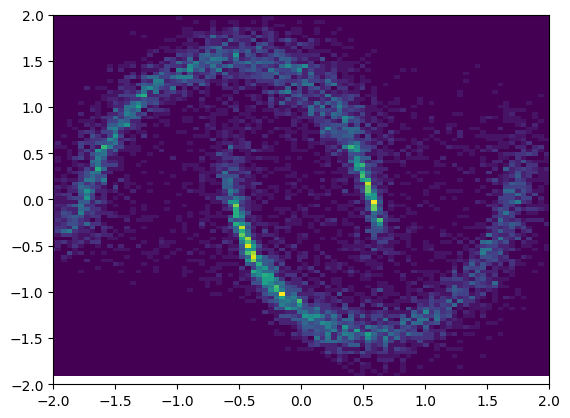

In [58]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

#### Sampling via solving the reverse-time SDE

The SDE has a corresponding reverse-time SDE,
$$\mathrm dx = [f(x,t) - g^2(t)\nabla_x \log p_t(x)]\mathrm d t + g(t)\mathrm dw$$
so that after estimating the score $\nabla_x \log p_t(x)$, we can solve this reverse SDE and and arrive at a sample from the data distribution.

In [71]:

def single_sample_fn(model, params, data_shape, dt0, t1, key):

    def drift(t, y, args):
        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))
        return -0.5 * beta * y - beta * model.apply(params, np.concatenate([y, t], -1))
    
    def diffusion(t, y, args):
        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))
        return np.sqrt(beta)

    t0 = 0
    bm = dfx.VirtualBrownianTree(t0, t1, tol=1e-5, shape=(1,), key=key)
    key, _ = jax.random.split(key)
    terms = dfx.MultiTerm(dfx.ODETerm(drift), dfx.ControlTerm(diffusion, bm))
    solver = dfx.Heun()
    y1 = jax.random.normal(key, data_shape)
    sol = dfx.diffeqsolve(terms, solver, t1, t0, -dt0, y1)
    
    return sol.ys[0]

In [75]:
dt = 0.05

single_sample_fn(score, params, (2,), dt, T, key)

Array([ 0.3941644, -1.2576884], dtype=float32, weak_type=True)

In [76]:
sample_fn = partial(single_sample_fn, score, params, (2,), dt, T)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)
x_sample = jax.vmap(sample_fn)(sample_key)

(-2.0, 2.0)

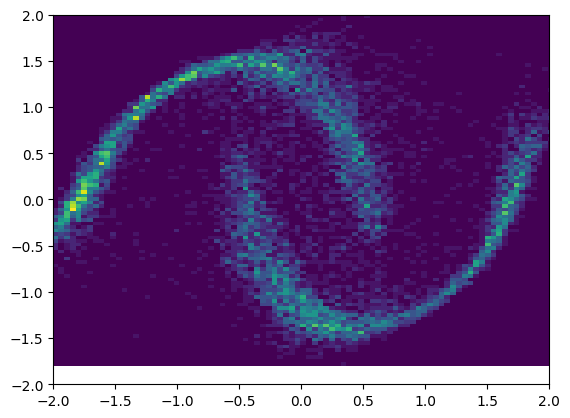

In [77]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

#### Sampling via manual implementation of Euler

$$x_{t - \Delta t} = x_t - [f(x,t) - g(t)^2 s_\theta(x_t,t)]\Delta t + g(t)\sqrt{\Delta t} z_t$$

In [78]:
def single_sample_fn(model, params, dt0, t1, key):

    t = t1
    xT = jax.random.normal(key, (2,))

    for _ in range(n_steps):
        
        key, _ = jax.random.split(key)

        t = np.atleast_1d(t)
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))

        a = -0.5 * beta * xT - beta * model.apply(params, np.concatenate([xT, t], -1))
        b = np.sqrt(beta)

        xT = xT - a * dt0 + b * np.sqrt(dt0) * jax.random.normal(key, xT.shape)
        t -= dt0

    return xT

n_steps = 100
dt = T / n_steps

key = jax.random.PRNGKey(42)

single_sample_fn(score, params, dt, T, key)

Array([-1.63598  ,  0.7669901], dtype=float32)

In [79]:
sample_fn = partial(single_sample_fn, score, params, dt, T)

n_samples = 100
sample_key = jax.random.split(key, n_samples ** 2)

x_sample = jax.vmap(sample_fn)(sample_key)

(-2.0, 2.0)

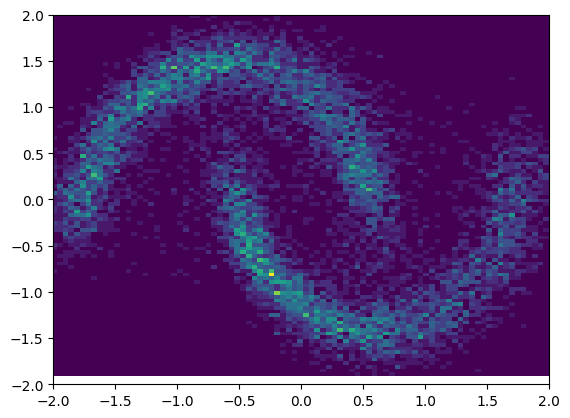

In [80]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)